In [1]:
import os
import librosa
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [2]:
!wget 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
!unzip mini_speech_commands.zip
!rm '/content/mini_speech_commands/README.md'

Streaming output truncated to the last 5000 lines.
  inflating: mini_speech_commands/up/1ecfb537_nohash_1.wav  
  inflating: __MACOSX/mini_speech_commands/up/._1ecfb537_nohash_1.wav  
  inflating: mini_speech_commands/up/c137814b_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._c137814b_nohash_0.wav  
  inflating: mini_speech_commands/up/135c6841_nohash_2.wav  
  inflating: __MACOSX/mini_speech_commands/up/._135c6841_nohash_2.wav  
  inflating: mini_speech_commands/up/3eb8764c_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._3eb8764c_nohash_0.wav  
  inflating: mini_speech_commands/up/caf9fceb_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._caf9fceb_nohash_0.wav  
  inflating: mini_speech_commands/up/f34e6f44_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._f34e6f44_nohash_0.wav  
  inflating: mini_speech_commands/up/61a0d340_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._61a0d340_nohash_0.wav  
  inflating: mini_

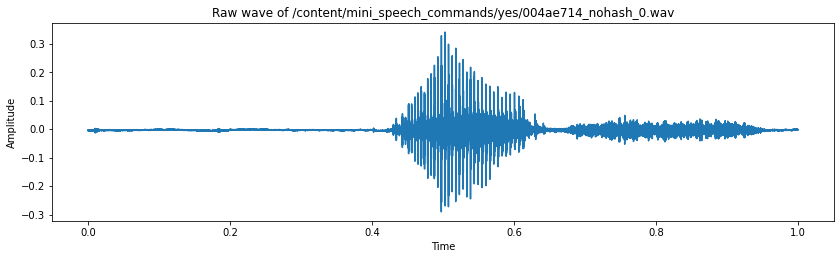

In [3]:
train_audio_path = '/content/mini_speech_commands/'
samples, sample_rate = librosa.load(train_audio_path + 'yes/004ae714_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '/content/mini_speech_commands/yes/004ae714_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [4]:
samples = librosa.resample(samples, sample_rate, 8000)

In [5]:
labels = os.listdir(train_audio_path)
labels

['right', 'down', 'up', 'left', 'no', 'stop', 'go', 'yes']

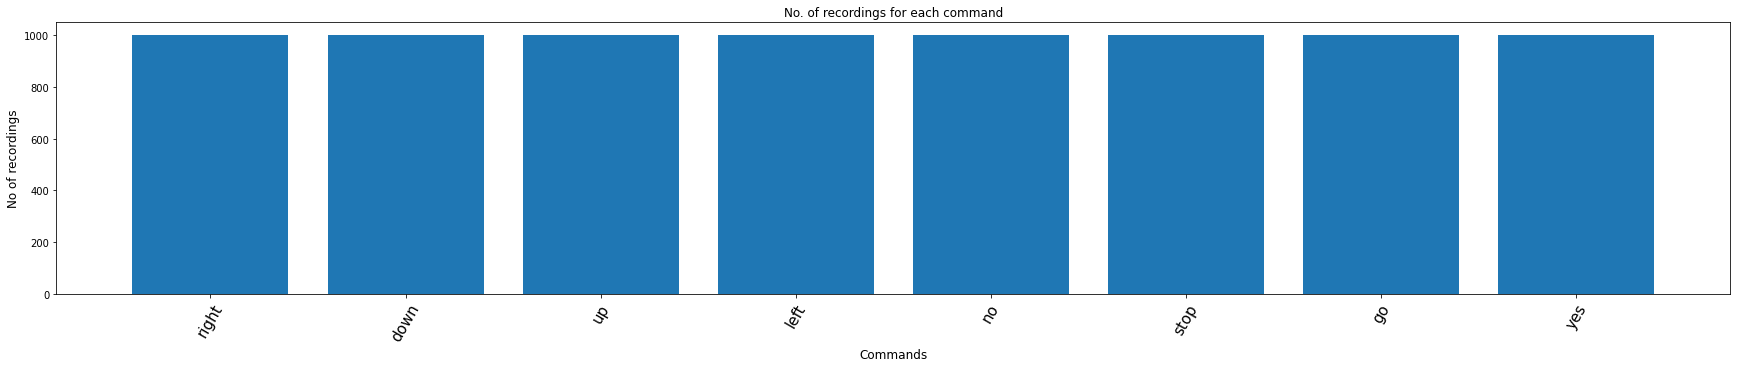

In [6]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [7]:
no_of_recordings

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

(array([   8.,    8.,   19.,   39.,   47.,  108.,   91.,  143.,  211.,
        7326.]),
 array([0.4266875 , 0.48401875, 0.54135   , 0.59868125, 0.6560125 ,
        0.71334375, 0.770675  , 0.82800625, 0.8853375 , 0.94266875,
        1.        ]),
 <a list of 10 Patch objects>)

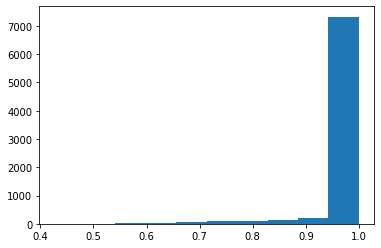

In [8]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [9]:
all_waves = []
all_labels = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

right
down
up
left
no
stop
go
yes


In [10]:
all_labels[:5],all_waves[:5]

(['right', 'right', 'right', 'right', 'right'],
 [array([ 0.00838302,  0.01237223,  0.01208919, ..., -0.01379598,
         -0.01361464, -0.0135415 ], dtype=float32),
  array([-0.00038051, -0.00049745, -0.00047335, ...,  0.00071929,
          0.0006254 ,  0.0005674 ], dtype=float32),
  array([-0.00105224, -0.00057464,  0.00194945, ...,  0.00234518,
          0.00209284,  0.00203578], dtype=float32),
  array([ 0.00036494,  0.00018627, -0.00028212, ..., -0.00157491,
         -0.00046856,  0.00045163], dtype=float32),
  array([0.00101508, 0.00216612, 0.00165088, ..., 0.00394456, 0.00318339,
         0.00428512], dtype=float32)])

In [11]:
def oneHotEncodingLabels(all_labels):
  le = LabelEncoder()
  y = le.fit_transform(all_labels)
  classes = list(le.classes_)
  y = np_utils.to_categorical(y, num_classes=len(labels))
  return y,classes

In [12]:
y,classes = oneHotEncodingLabels(all_labels)
all_waves = np.array(all_waves).reshape(-1,8000,1)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(all_waves), np.array(y), stratify = y, test_size = 0.32,random_state = 42, shuffle=True)

In [14]:
from tensorflow import keras

model = keras.Sequential([
              keras.layers.Conv1D(8,13, padding='valid', activation='relu', strides=1, input_shape=(8000,1)),
              keras.layers.MaxPooling1D(3),
              keras.layers.Dropout(0.3),

              keras.layers.Conv1D(16, 11, padding='valid', activation='relu', strides=1),
              keras.layers.MaxPooling1D(3),
              keras.layers.Dropout(0.3),

              keras.layers.Conv1D(32, 9, padding='valid', activation='relu', strides=1),
              keras.layers.MaxPooling1D(3),
              keras.layers.Dropout(0.3),

              keras.layers.Flatten(),
              keras.layers.Dense(256, activation='relu'),
              keras.layers.Dropout(0.3),
              keras.layers.Dense(128, activation='relu'),
              keras.layers.Dropout(0.3),
              keras.layers.Dense(len(labels), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 884, 16)           0

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
history = model.fit(x_train, y_train ,epochs=100, batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
153/153 [==============================] - 36s 231ms/step - loss: 2.0169 - accuracy: 0.1903 - val_loss: 1.8940 - val_accuracy: 0.2477
Epoch 2/100
153/153 [==============================] - 35s 231ms/step - loss: 1.7349 - accuracy: 0.3188 - val_loss: 1.5575 - val_accuracy: 0.4040
Epoch 3/100
153/153 [==============================] - 35s 229ms/step - loss: 1.5216 - accuracy: 0.4145 - val_loss: 1.3637 - val_accuracy: 0.4789
Epoch 4/100
153/153 [==============================] - 35s 230ms/step - loss: 1.3573 - accuracy: 0.4761 - val_loss: 1.2709 - val_accuracy: 0.5398
Epoch 5/100
153/153 [==============================] - 35s 229ms/step - loss: 1.2495 - accuracy: 0.5271 - val_loss: 1.2090 - val_accuracy: 0.5712
Epoch 6/100
153/153 [==============================] - 35s 230ms/step - loss: 1.1481 - accuracy: 0.5648 - val_loss: 1.1318 - val_accuracy: 0.5877
Epoch 7/100
153/153 [==============================] - 35s 230ms/step - loss: 1.0611 - accuracy: 0.5911 - val_loss: 1.1093 -

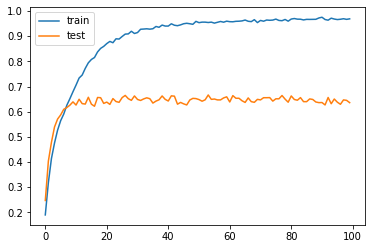

In [20]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

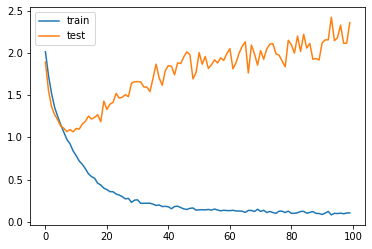

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
import random
index = random.randint(0,len(x_val)-1)
samples = x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])

Audio: yes


In [19]:
prob = model.predict(samples.reshape(1,8000,1))
index = np.argmax(prob[0])
print("Predicted:",classes[index])

Predicted: yes
